Turnstile
========

From turnstile data, see how MTA `#ServiceAlert` tweets affect in-/out-flow rates of passengers. Predict change in those values, and estimate future disuptions.

- **Why:** MTA could improve station capabilities at heavily or more frequently affected locations, pure numbers of passengers can point to stations to avoid, or cascading delays on connecting trains
- **How:** MTA turnstile backlogs for years, MTA tweets since mid-May 2017, fake Twitter user putting out alert tweets

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = 'turnstile_170520.txt'

In [2]:
def read_turnstiles(filename):
    df = pd.read_csv(filename, header=0)
    df.columns = df.columns.str.strip().str.lower()
    df['datetime'] = pd.to_datetime(df.date + df.time, format='%m/%d/%Y%H:%M:%S')
    df.drop(['division', 'desc', 'time'], axis=1, inplace=True)
    return df

data = read_turnstiles(filename)
data.head()

,c/a,unit,scp,station,linename,date,entries,exits,datetime
0,A002,R051,02-00-00,59 ST,NQR456W,05/13/2017,6175956,2091935,2017-05-13 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,05/13/2017,6176001,2091936,2017-05-13 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,05/13/2017,6176032,2091960,2017-05-13 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,05/13/2017,6176121,2092061,2017-05-13 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,05/13/2017,6176394,2092119,2017-05-13 16:00:00


In [3]:
data[data.station == 'LEXINGTON AV/63'].linename.unique()

array(['F'], dtype=object)

In [3]:
import os

files = sorted(os.listdir('modern'))
files = [f'modern/{f}' for f in files]
start_file = files.pop(0)
start_file

'modern/turnstile_141018.txt'

In [4]:
frames = []

for file in files:
    df = read_turnstiles(file)
    penn = df[df.station == '34 ST-PENN STA']
    penn.set_index(['datetime'], inplace=True)
    frames.append(penn)

In [5]:
len(frames)

136

In [6]:
penn_modern = pd.concat(frames, axis=0)
penn_modern.head()

,c/a,unit,scp,station,linename,date,entries,exits
datetime,,,,,,,,
2014-10-18 00:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,10/18/2014,1073310.0,737034.0
2014-10-18 04:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,10/18/2014,1073325.0,737036.0
2014-10-18 08:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,10/18/2014,1073349.0,737047.0
2014-10-18 12:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,10/18/2014,1073439.0,737146.0
2014-10-18 16:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,10/18/2014,1073566.0,737192.0


Diffs
====

I can't figure out how to make diffs work properly with multi-index, so I'll break things down into separate frames, calculate the diffs, then recombine.

Generate diffs for the entire thing now...

In [7]:
frames = []
for unit in penn_modern.unit.unique():
    scps = penn_modern[penn_modern.unit == unit].scp.unique()
    for scp in scps:
        frame = penn_modern[(penn_modern.unit == unit) & (penn_modern.scp == scp)]
        diffs = frame[['entries', 'exits']].diff()
        diffs.columns = ['d_entries', 'd_exits']
        frame = pd.concat([frame, diffs], axis=1)
        frame.drop(['entries', 'exits'], axis=1, inplace=True)
        frame.dropna(inplace=True)
        frames.append(frame)

diff_penn = pd.concat(frames, axis=0)
diff_penn.head()

,c/a,unit,scp,station,linename,date,d_entries,d_exits
datetime,,,,,,,,
2014-10-18 04:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,10/18/2014,15.0,2.0
2014-10-18 08:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,10/18/2014,24.0,11.0
2014-10-18 12:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,10/18/2014,90.0,99.0
2014-10-18 16:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,10/18/2014,127.0,46.0
2014-10-18 20:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,10/18/2014,126.0,71.0


In [8]:
diff_penn = pd.concat(frames, axis=0)
diff_penn.reset_index(inplace=True)
diff_penn.date = pd.to_datetime(diff_penn.date, format='%m/%d/%Y')
by_day = diff_penn.groupby('date').sum()
# by_time.drop('index', inplace=True)
by_day.head()

,d_entries,d_exits
date,,
2014-10-18,8.369800e+04,81119.0
2014-10-19,9.183800e+04,77482.0
2014-10-20,1.834470e+05,151642.0
2014-10-21,1.955443e+09,484812905.0
2014-10-22,1.943280e+05,167096.0


In [9]:
by_day.describe()

,d_entries,d_exits
count,9.520000e+02,9.520000e+02
mean,2.316296e+06,1.259383e+06
std,1.042944e+08,4.510951e+07
min,-1.975960e+09,-4.894037e+08
25%,9.298950e+04,8.459225e+04
50%,1.722440e+05,1.436510e+05
75%,1.815275e+05,1.533415e+05
max,1.955443e+09,1.126536e+09


There's a lot of erroneous points from where different carosels shifted their counts... Instead of trying to manually fix these, let's just descriminate based on a conservative value of < 100,000 for passenger flow per time.

That wasn't good enough, so for here 10,000 was fine, plus getting rid of negative values.

In [10]:
by_day[((by_day.d_entries > 1e6) | (by_day.d_exits > 1e6))
       | ((by_day.d_entries < 0) & (by_day.d_exits < 0))].count()

d_entries    32
d_exits      32
dtype: int64

In [11]:
by_day_filtered = by_day[((by_day.d_entries < 1e6) & (by_day.d_exits < 1e6))
                         & ((by_day.d_entries > 0) & (by_day.d_exits > 0))]

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


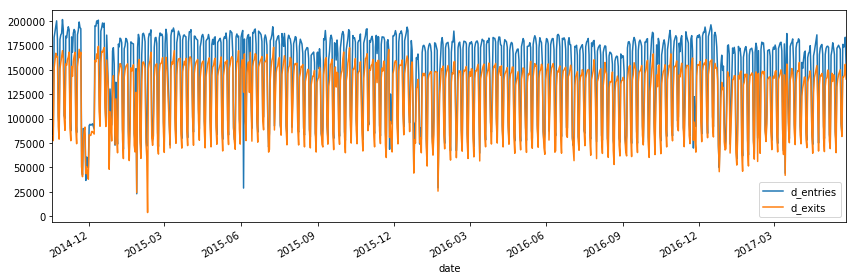

In [12]:
by_day_filtered.plot(kind='line', y=['d_entries', 'd_exits'], figsize=(12, 4))

Day of Week
-------------

Fluctuations based on day of week, and time of day...

In [13]:
by_day_filtered['weekday'] = by_day_filtered.index.weekday.get_values()

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
by_day_filtered.head()

,d_entries,d_exits,weekday
date,,,
2014-10-18,83698.0,81119.0,5
2014-10-19,91838.0,77482.0,6
2014-10-20,183447.0,151642.0,0
2014-10-22,194328.0,167096.0,2
2014-10-23,200327.0,163371.0,3


(0, 200000)

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


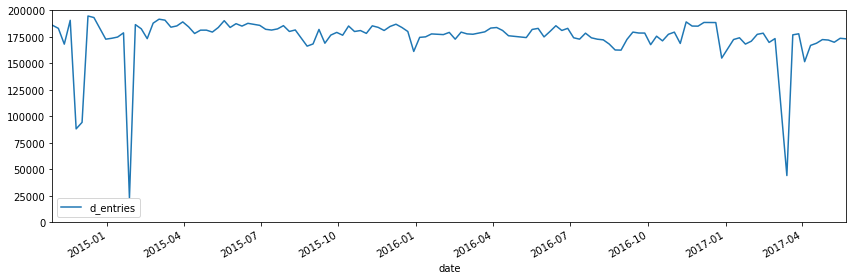

In [15]:
ax = by_day_filtered[by_day_filtered.weekday == 1].plot(kind='line', y='d_entries',
                                                        figsize=(12, 4))
ax.set_ylim(0, 200000)